In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style='whitegrid')
df = pd.read_csv('CollegePlacement.csv')

In [5]:
# Overview of data
print('Basic Info')
df.info()

df.describe()

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.532379,5.546400,4.970900,5.561800,2.513400
std,15.053101,1.447519,1.470141,2.873477,3.160103,2.900866,1.715959
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000
max,158.000000,10.000000,10.460000,10.000000,10.000000,10.000000,5.000000


In [11]:
# Data cleaning
missing_values = df.isnull().sum()
print(missing_values)
# No missing values

College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64


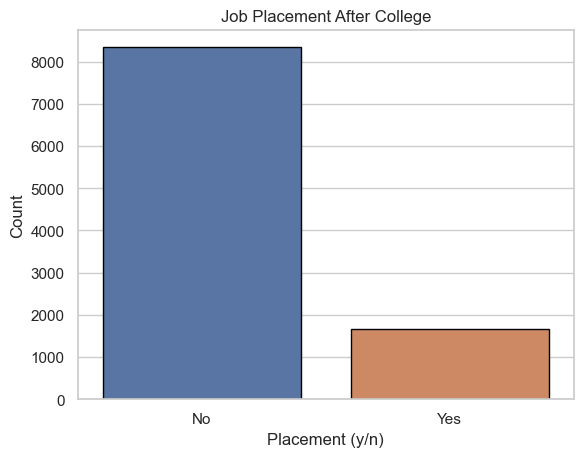

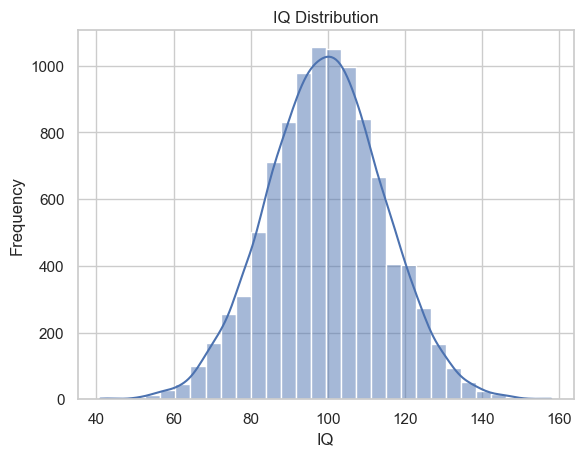

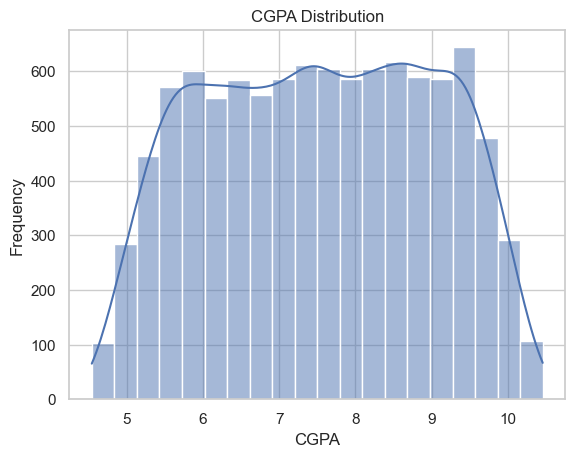

In [ ]:
# Preliminary Analysis

# Histogram of Job Placements
plt.figure()
sns.countplot(x = 'Placement', data = df, palette='deep', edgecolor='black')
plt.title('Job Placement After College')
plt.xlabel('Placement (y/n)')
plt.ylabel('Count')
plt.show()

# IQ Distribution
plt.figure()
sns.histplot(df['IQ'], bins = 30, kde = True)
plt.title('IQ Distribution')
plt.xlabel('IQ')
plt.ylabel('Frequency')
plt.show()
# almost perfect bell shape!

# Cumulative GPA Distribution
plt.figure()
sns.histplot(df['CGPA'], bins = 20, kde = True)
plt.title('CGPA Distribution')
plt.xlabel('CGPA')
plt.ylabel('Frequency')
plt.show()

